<a href="https://colab.research.google.com/github/MDunitz/Apollo-11/blob/master/CellxGene_Query_PCA_CellClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installing package
!pip install cellxgene-census


In [ ]:
import pandas as pd
import numpy as np
import cellxgene_census
import tiledbsoma
import anndata as ad
import scanpy as sc
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

census = cellxgene_census.open_soma(census_version="2024-07-01")

In [ ]:
summary_table = census["census_info"]["summary_cell_counts"].read().concat().to_pandas()

summary_table.query("organism == 'Homo sapiens' & category == 'tissue_general' & label =='brain'")

,soma_joinid,organism,category,label,ontology_term_id,total_cell_count,unique_cell_count
1148,1148,Homo sapiens,tissue_general,brain,UBERON:0000955,26281059,13776355


In [ ]:
adata = cellxgene_census.get_anndata(
    census=census,
    organism="Homo sapiens",
    # var_value_filter="feature_id in ['ENSG00000161798', 'ENSG00000188229']",
    obs_value_filter="is_primary_data == True and donor_id == 'sanes_Pt2'",
    obs_column_names=["cell_type", "cell_type_ontology_term_id", "sex", "assay", "disease", "disease_ontology_term_id"],
)

In [ ]:
adata

AnnData object with n_obs × n_vars = 16601 × 60530
    obs: 'cell_type', 'cell_type_ontology_term_id', 'sex', 'assay', 'disease', 'disease_ontology_term_id', 'is_primary_data', 'donor_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'

In [ ]:
adata.var

,soma_joinid,feature_id,feature_name,feature_length,nnz,n_measured_obs
0,0,ENSG00000000003,TSPAN6,4530,4530448,73855064
1,1,ENSG00000000005,TNMD,1476,236059,61201828
2,2,ENSG00000000419,DPM1,9276,17576462,74159149
3,3,ENSG00000000457,SCYL3,6883,9117322,73988868
4,4,ENSG00000000460,C1orf112,5970,6287794,73636201
...,...,...,...,...,...,...
60525,60525,ENSG00000288718,ENSG00000288718.1,1070,4,1248980
60526,60526,ENSG00000288719,ENSG00000288719.1,4252,2826,1248980
60527,60527,ENSG00000288724,ENSG00000288724.1,625,36,1248980
60528,60528,ENSG00000290791,ENSG00000290791.1,3612,1642,43485


In [ ]:
adata.obs

,cell_type,cell_type_ontology_term_id,sex,assay,disease,disease_ontology_term_id,is_primary_data,donor_id
0,retina horizontal cell,CL:0000745,male,10x 3' v2,normal,PATO:0000461,True,sanes_Pt2
1,retina horizontal cell,CL:0000745,male,10x 3' v2,normal,PATO:0000461,True,sanes_Pt2
2,retina horizontal cell,CL:0000745,male,10x 3' v2,normal,PATO:0000461,True,sanes_Pt2
3,retina horizontal cell,CL:0000745,male,10x 3' v2,normal,PATO:0000461,True,sanes_Pt2
4,retina horizontal cell,CL:0000745,male,10x 3' v2,normal,PATO:0000461,True,sanes_Pt2
...,...,...,...,...,...,...,...,...
16596,pigmented ciliary epithelial cell,CL:0002303,male,10x 3' v3,normal,PATO:0000461,True,sanes_Pt2
16597,Schwann cell,CL:0002573,male,10x 3' v3,normal,PATO:0000461,True,sanes_Pt2
16598,pigmented ciliary epithelial cell,CL:0002303,male,10x 3' v3,normal,PATO:0000461,True,sanes_Pt2
16599,ciliary muscle cell,CL:1000443,male,10x 3' v3,normal,PATO:0000461,True,sanes_Pt2


In [ ]:
print(adata.obs.columns)


Index(['cell_type', 'cell_type_ontology_term_id', 'sex', 'assay', 'disease',
       'disease_ontology_term_id', 'is_primary_data', 'donor_id'],
      dtype='object')


In [ ]:
cell_type_counts = adata.obs['cell_type'].value_counts()
print(cell_type_counts.head(50))  # Prints the first 20 rows


cell_type
pigmented ciliary epithelial cell                  5814
Mueller cell                                       2152
non-pigmented ciliary epithelial cell              1901
retinal ganglion cell                              1474
ON-bipolar cell                                    1053
OFF-bipolar cell                                   1024
Schwann cell                                        712
fibroblast                                          691
ciliary muscle cell                                 526
melanocyte                                          393
retina horizontal cell                              280
macrophage                                          233
GABAergic amacrine cell                              93
retinal cone cell                                    67
retinal rod cell                                     45
microglial cell                                      37
lymphocyte                                           35
blood vessel endothelial cell         

In [ ]:
# Remove cell types with fewer than 20 cells in total dataset

cell_type_counts = adata.obs['cell_type'].value_counts()
cell_types_to_keep = cell_type_counts[cell_type_counts > 20].index.tolist()
adata = adata[adata.obs['cell_type'].isin(cell_types_to_keep)].copy()

In [ ]:
# removing genes that are lowly expressed (found in more than 20 cells in our data)
adata = adata[:, adata.X.sum(axis=0) > 20]
adata

View of AnnData object with n_obs × n_vars = 16582 × 25090
    obs: 'cell_type', 'cell_type_ontology_term_id', 'sex', 'assay', 'disease', 'disease_ontology_term_id', 'is_primary_data', 'donor_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'

# Exploratory Data Analysis (EDA) of single-cell data

In [ ]:
print(adata)

View of AnnData object with n_obs × n_vars = 16582 × 25090
    obs: 'cell_type', 'cell_type_ontology_term_id', 'sex', 'assay', 'disease', 'disease_ontology_term_id', 'is_primary_data', 'donor_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'


## Normalizing Data

In [ ]:
# Calculate total counts per cell (if not already calculated)
adata.obs['total_counts'] = adata.X.sum(axis=1)

# Normalize the data
# This function will scale each cell to have 10,000 total counts and then log-transform
sc.pp.normalize_total(adata, target_sum=1e4)

# Log-transform the data
sc.pp.log1p(adata)


<ipython-input-33-c6c44e700c93>:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['total_counts'] = adata.X.sum(axis=1)


## Visualizing data with Dimensionality Reduction

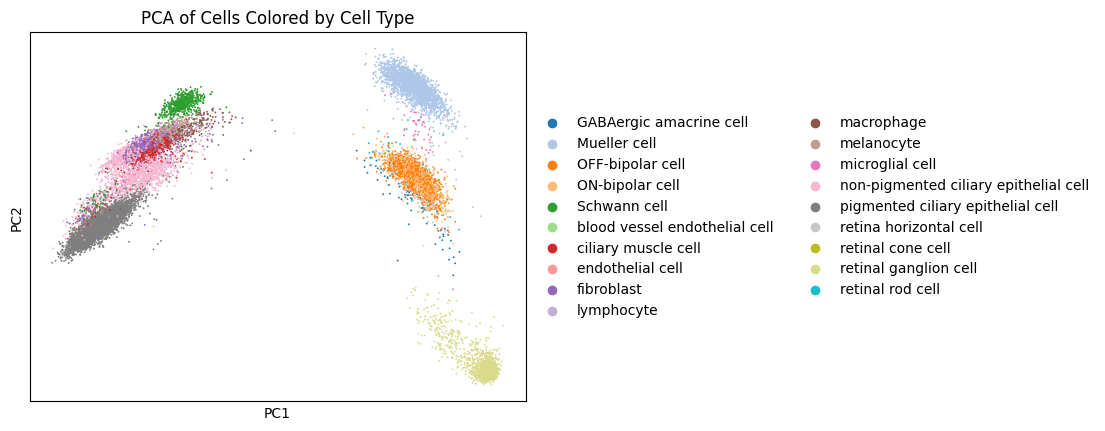

In [ ]:
# Performing PCA
sc.tl.pca(adata, svd_solver='arpack')

# Plotting PCA
sc.pl.pca(adata, color='cell_type', title="PCA of Cells Colored by Cell Type", palette=sc.pl.palettes.vega_20)


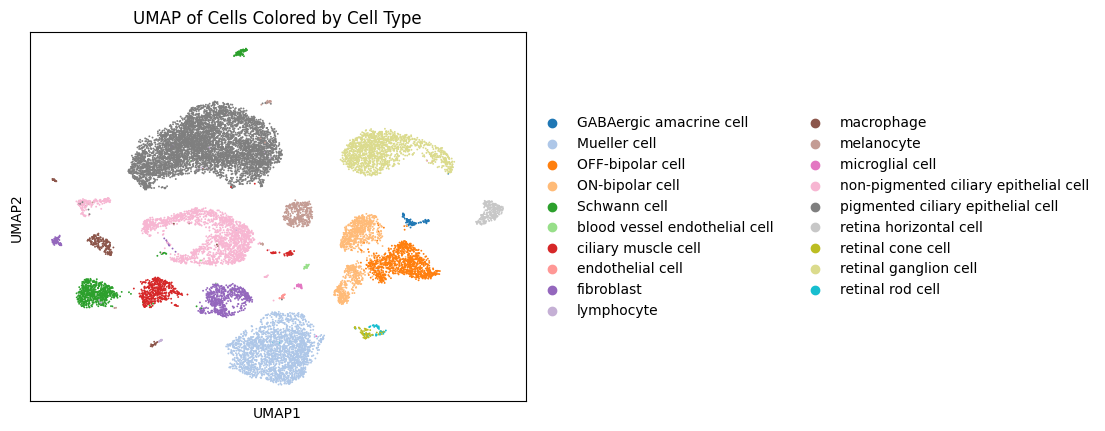

In [ ]:
# Calculate UMAP embedding
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

# Plotting UMAP
sc.pl.umap(adata, color='cell_type', title='UMAP of Cells Colored by Cell Type', palette=sc.pl.palettes.vega_20)

# Cell Type Classification

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets, stratified by 'cell_type'
adata_train, adata_test = train_test_split(
    adata, test_size=0.3, stratify=adata.obs['cell_type'], random_state=42
)

print(f"Training set size: {adata_train.shape[0]}")
print(f"Testing set size: {adata_test.shape[0]}")

Training set size: 11607
Testing set size: 4975


In [ ]:
print(adata_train)
print(adata_test)

View of AnnData object with n_obs × n_vars = 11607 × 25090
    obs: 'cell_type', 'cell_type_ontology_term_id', 'sex', 'assay', 'disease', 'disease_ontology_term_id', 'is_primary_data', 'donor_id', 'total_counts'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    uns: 'log1p', 'pca', 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
View of AnnData object with n_obs × n_vars = 4975 × 25090
    obs: 'cell_type', 'cell_type_ontology_term_id', 'sex', 'assay', 'disease', 'disease_ontology_term_id', 'is_primary_data', 'donor_id', 'total_counts'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    uns: 'log1p', 'pca', 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


In [ ]:
print(adata_train.obs['cell_type'].value_counts())
print(adata_test.obs['cell_type'].value_counts())

cell_type
pigmented ciliary epithelial cell        4070
Mueller cell                             1506
non-pigmented ciliary epithelial cell    1331
retinal ganglion cell                    1032
ON-bipolar cell                           737
OFF-bipolar cell                          717
Schwann cell                              498
fibroblast                                484
ciliary muscle cell                       368
melanocyte                                275
retina horizontal cell                    196
macrophage                                163
GABAergic amacrine cell                    65
retinal cone cell                          47
retinal rod cell                           31
microglial cell                            26
lymphocyte                                 24
blood vessel endothelial cell              19
endothelial cell                           18
Name: count, dtype: int64
cell_type
pigmented ciliary epithelial cell        1744
Mueller cell                      

Wrangling gene expression data into the proper format

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Convert sparse matrix to dense array
X_train = adata_train.X.toarray()
y_train = adata_train.obs['cell_type']

X_test = adata_test.X.toarray()
y_test = adata_test.obs['cell_type']

## Training a Multinomial Logistic Regression Classifer of Cell Types

In [ ]:
# Train a Multinomial Logistic Regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.9933668341708543
                                       precision    recall  f1-score   support

              GABAergic amacrine cell       1.00      1.00      1.00        28
                         Mueller cell       1.00      1.00      1.00       646
                     OFF-bipolar cell       0.99      0.98      0.99       307
                      ON-bipolar cell       0.98      0.99      0.99       316
                         Schwann cell       0.99      1.00      0.99       214
        blood vessel endothelial cell       1.00      1.00      1.00         8
                  ciliary muscle cell       0.99      0.99      0.99       158
                     endothelial cell       0.88      1.00      0.93         7
                           fibroblast       1.00      1.00      1.00       207
                           lymphocyte       1.00      0.27      0.43        11
                           macrophage       0.99      0.97      0.98        70
                      

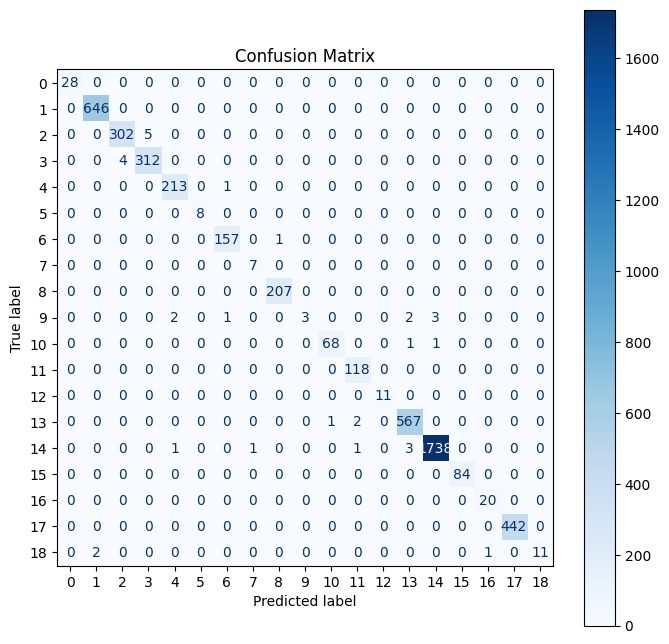

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()